In [1]:
import torch
import torchvision
from components import NeuralProcess
from matplotlib import pyplot as plt
from torch import nn
from train_val import train_and_validate
from utils import DataModule, img_to_x_y, split_context_target, x_y_to_img

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='/home/chickencurry/diffusion-vi-neural-processes/data', 
    train=True, 
    transform=transform, 
    download=False)

val_dataset = torchvision.datasets.MNIST(
    root='/home/chickencurry/diffusion-vi-neural-processes/data', 
    train=False, 
    transform=transform, 
    download=False)

data_module = DataModule(
    batch_size=512,
    train_and_val_set=(train_dataset, val_dataset)
)

In [4]:
model = NeuralProcess(
    x_dim=2, 
    y_dim=1, 
    r_dim=16, 
    z_dim=16, 
    h_dim=256, 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
recon_criterion = nn.BCEWithLogitsLoss(reduction='mean')

In [5]:
avg_train_recon_losses = []
avg_train_kl_divs = []

avg_val_recon_losses = []
avg_val_kl_divs = []

In [6]:
losses = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=40,
    device=device,
    optimizer=optimizer,
    preprocessing=lambda batch: img_to_x_y(batch[0]),
)

avg_train_recon_losses.extend(losses[0])
avg_train_kl_divs.extend(losses[1])

avg_val_recon_losses.extend(losses[2])
avg_val_kl_divs.extend(losses[3])

  0%|          | 0/118 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


avg_train_recon_loss:  191.6383632724568
avg_train_kl_div:  0.09985635070287094


100%|██████████| 20/20 [00:02<00:00,  6.86it/s]


avg_val_recon_loss:  195.0772271156311
avg_val_kl_div:  0.003570837607549038


100%|██████████| 118/118 [00:53<00:00,  2.20it/s]


avg_train_recon_loss:  183.48511112342447
avg_train_kl_div:  0.002500571183468387


100%|██████████| 20/20 [00:03<00:00,  6.66it/s]


avg_val_recon_loss:  186.74096536636353
avg_val_kl_div:  0.0010939056861388962


100%|██████████| 118/118 [00:53<00:00,  2.22it/s]


avg_train_recon_loss:  178.564370995861
avg_train_kl_div:  0.0005131706205833387


100%|██████████| 20/20 [00:02<00:00,  7.06it/s]


avg_val_recon_loss:  181.21969776153566
avg_val_kl_div:  0.00017629790745559147


100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


avg_train_recon_loss:  195.13601823580467
avg_train_kl_div:  0.0004745512317686778


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


avg_val_recon_loss:  191.82498989105224
avg_val_kl_div:  0.0007705978647209122


100%|██████████| 118/118 [00:50<00:00,  2.32it/s]


avg_train_recon_loss:  178.76480568061442
avg_train_kl_div:  0.0004324961973444738


100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


avg_val_recon_loss:  177.08477687835693
avg_val_kl_div:  0.00020402598115651927


100%|██████████| 118/118 [00:50<00:00,  2.35it/s]


avg_train_recon_loss:  178.3221629352893
avg_train_kl_div:  0.0002594731156362178


100%|██████████| 20/20 [00:02<00:00,  7.24it/s]


avg_val_recon_loss:  212.63513679504393
avg_val_kl_div:  0.0002812984054799017


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  180.69447764703784
avg_train_kl_div:  0.0001441958277001057


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


avg_val_recon_loss:  174.04592962265014
avg_val_kl_div:  6.702859100187198e-05


100%|██████████| 118/118 [00:50<00:00,  2.35it/s]


avg_train_recon_loss:  172.67045916541147
avg_train_kl_div:  8.715658794367839e-05


100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


avg_val_recon_loss:  202.55118036270142
avg_val_kl_div:  0.00017708334542021475


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  202.59114768141407
avg_train_kl_div:  0.00023872552467271477


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


avg_val_recon_loss:  210.85773048400878
avg_val_kl_div:  0.00010297983485543227


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  183.41328005063332
avg_train_kl_div:  0.00013688252376896807


100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


avg_val_recon_loss:  206.9557373046875
avg_val_kl_div:  0.00012194354467283119


100%|██████████| 118/118 [00:50<00:00,  2.32it/s]


avg_train_recon_loss:  193.7640138399803
avg_train_kl_div:  8.628549219396117e-05


100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


avg_val_recon_loss:  171.83376522064208
avg_val_kl_div:  0.00010076443395519163


100%|██████████| 118/118 [00:50<00:00,  2.35it/s]


avg_train_recon_loss:  163.73994748067048
avg_train_kl_div:  9.559101340335597e-05


100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


avg_val_recon_loss:  177.93733444213868
avg_val_kl_div:  3.9697379065728455e-05


100%|██████████| 118/118 [00:49<00:00,  2.36it/s]


avg_train_recon_loss:  192.51889838202524
avg_train_kl_div:  0.00011827148379589066


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


avg_val_recon_loss:  144.68187131881714
avg_val_kl_div:  0.00010616938811836008


100%|██████████| 118/118 [00:50<00:00,  2.33it/s]


avg_train_recon_loss:  159.59068831750903
avg_train_kl_div:  6.500527481652386e-05


100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


avg_val_recon_loss:  213.97967052459717
avg_val_kl_div:  2.0237955709490052e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  185.65131295737572
avg_train_kl_div:  4.708193425360258e-05


100%|██████████| 20/20 [00:02<00:00,  7.12it/s]


avg_val_recon_loss:  238.67081985473632
avg_val_kl_div:  3.255646024626913e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  185.2195162369033
avg_train_kl_div:  2.9895941398724634e-05


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


avg_val_recon_loss:  193.0597626686096
avg_val_kl_div:  1.659917407437206e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  175.40925161717303
avg_train_kl_div:  0.00012519148006569626


100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


avg_val_recon_loss:  184.50316257476806
avg_val_kl_div:  3.7612700043609945e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  166.99988842010498
avg_train_kl_div:  2.8969567284582932e-05


100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


avg_val_recon_loss:  204.05247735977173
avg_val_kl_div:  1.881554257465723e-05


100%|██████████| 118/118 [00:49<00:00,  2.36it/s]


avg_train_recon_loss:  165.38513154498602
avg_train_kl_div:  7.263185495351196e-05


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


avg_val_recon_loss:  197.52717351913452
avg_val_kl_div:  2.0147690253224938e-05


100%|██████████| 118/118 [00:50<00:00,  2.36it/s]


avg_train_recon_loss:  177.8311983852063
avg_train_kl_div:  4.217957958765941e-05


100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


avg_val_recon_loss:  143.57173337936402
avg_val_kl_div:  2.8255731876924983e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  178.16208050614696
avg_train_kl_div:  2.276541809729964e-05


100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


avg_val_recon_loss:  160.73246507644654
avg_val_kl_div:  3.744842904325196e-05


100%|██████████| 118/118 [00:50<00:00,  2.36it/s]


avg_train_recon_loss:  181.8216902845997
avg_train_kl_div:  1.876426981084478e-05


100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


avg_val_recon_loss:  189.4335391998291
avg_val_kl_div:  7.21636042726459e-06


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  193.94100879410567
avg_train_kl_div:  2.3837155078284675e-05


100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


avg_val_recon_loss:  130.68269662857057
avg_val_kl_div:  4.663089147811661e-05


100%|██████████| 118/118 [00:50<00:00,  2.35it/s]


avg_train_recon_loss:  169.3508410696256
avg_train_kl_div:  3.08225176531219e-05


100%|██████████| 20/20 [00:03<00:00,  6.26it/s]


avg_val_recon_loss:  205.35370788574218
avg_val_kl_div:  5.637325222096478e-06


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  172.76956808769097
avg_train_kl_div:  1.1687098308270526e-05


100%|██████████| 20/20 [00:02<00:00,  7.05it/s]


avg_val_recon_loss:  141.238671875
avg_val_kl_div:  1.6121355990605934e-05


100%|██████████| 118/118 [00:50<00:00,  2.36it/s]


avg_train_recon_loss:  168.52058433274092
avg_train_kl_div:  1.1592448009252113e-05


100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


avg_val_recon_loss:  204.42732458114625
avg_val_kl_div:  4.5164646820694545e-06


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  178.9103498135583
avg_train_kl_div:  5.763921454531382e-05


100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


avg_val_recon_loss:  202.63192195892333
avg_val_kl_div:  0.00020702672691186308


100%|██████████| 118/118 [00:49<00:00,  2.36it/s]


avg_train_recon_loss:  184.25313225439038
avg_train_kl_div:  3.141757528768629e-05


100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


avg_val_recon_loss:  199.1519973754883
avg_val_kl_div:  9.044192609053425e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  186.89559210761118
avg_train_kl_div:  0.0003927064696574304


100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


avg_val_recon_loss:  135.29950160980223
avg_val_kl_div:  0.00048617905756600523


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  193.77887643393822
avg_train_kl_div:  0.0001519087483306282


100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


avg_val_recon_loss:  201.33527059555053
avg_val_kl_div:  1.400099689021772e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  178.12785282781567
avg_train_kl_div:  1.1660202655559907e-05


100%|██████████| 20/20 [00:02<00:00,  7.17it/s]


avg_val_recon_loss:  161.2827205657959
avg_val_kl_div:  1.4926336055509637e-05


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  191.26242831601934
avg_train_kl_div:  1.955436565797261e-05


100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


avg_val_recon_loss:  177.41442928314208
avg_val_kl_div:  4.662417413214825e-06


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  170.37871714769784
avg_train_kl_div:  8.191660784031213e-06


100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


avg_val_recon_loss:  154.20989351272584
avg_val_kl_div:  1.45293714567174e-05


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  192.22924022351282
avg_train_kl_div:  1.3710704110789558e-05


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


avg_val_recon_loss:  201.3151804924011
avg_val_kl_div:  3.834848092765241e-06


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  179.59329501653121
avg_train_kl_div:  5.322064803593448e-06


100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


avg_val_recon_loss:  188.63413534164428
avg_val_kl_div:  1.3731739210243177e-05


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  182.02879385220803
avg_train_kl_div:  2.427704862480761e-06


100%|██████████| 20/20 [00:02<00:00,  7.21it/s]


avg_val_recon_loss:  202.88727445602416
avg_val_kl_div:  3.95486247413146e-06


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  177.63102875725698
avg_train_kl_div:  2.706066138054697e-06


100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


avg_val_recon_loss:  174.9071502685547
avg_val_kl_div:  2.279184486297936e-05


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  180.4887317398847
avg_train_kl_div:  2.1486907094108804e-06


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


avg_val_recon_loss:  194.690726852417
avg_val_kl_div:  9.370125617635949e-07


100%|██████████| 118/118 [00:49<00:00,  2.38it/s]


avg_train_recon_loss:  189.55707205756235
avg_train_kl_div:  5.407729421892589e-06


100%|██████████| 20/20 [00:02<00:00,  7.17it/s]


avg_val_recon_loss:  184.77218647003173
avg_val_kl_div:  1.596628285795987e-05


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


avg_train_recon_loss:  182.81854611736233
avg_train_kl_div:  5.42021775246112e-05


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]

avg_val_recon_loss:  152.74389781951905
avg_val_kl_div:  2.1803202179171423e-05


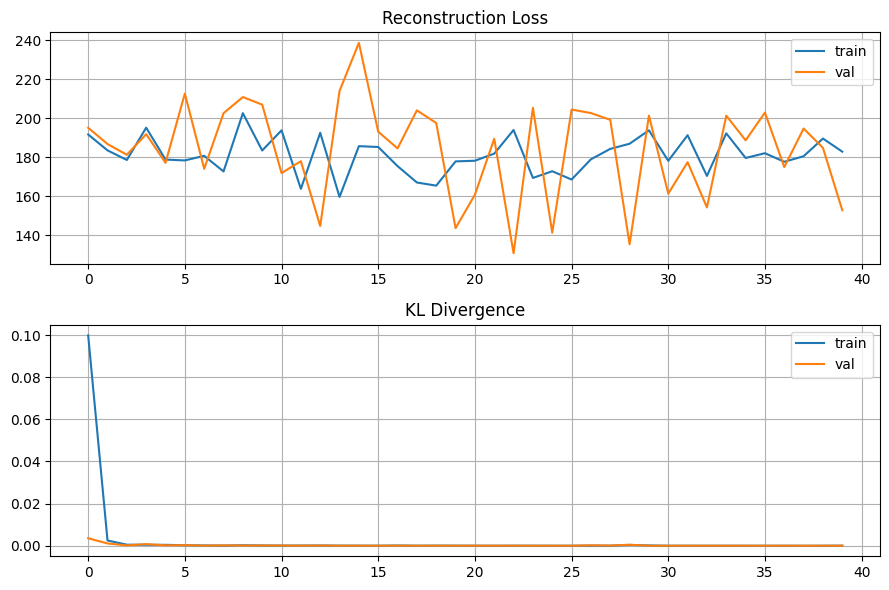

In [32]:
_, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(avg_train_recon_losses, label="train")
ax[0].plot(avg_val_recon_losses, label="val")
ax[0].set_title("Reconstruction Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [30]:
gen_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=True)
sample = next(iter(gen_dataloader))

x_data, y_data = img_to_x_y(sample[0])
x_data, y_data = x_data.to(device), y_data.to(device)

factor = 0.8
x_context, y_context, x_target, y_target = split_context_target(x_data, y_data, factor, random=False)

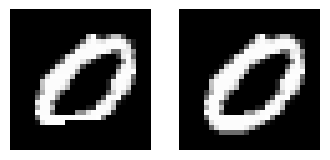

In [31]:
n_samples = 1

model.eval()
with torch.no_grad():
    
    mus, logvars, _, _ = model.sample(x_context, y_context, x_target, n_samples)
    mus = torch.sigmoid(mus)

    x_new = torch.cat([x_context, x_target], dim=1).cpu()
    y_new = torch.cat([y_context, mus], dim=1).cpu()

    img_batch = x_y_to_img(x_new, y_new)

    fig, ax = plt.subplots(1, 2, figsize=(4, 8))

    ax[0].imshow(img_batch[0].detach().cpu().permute(1, 2, 0), cmap="gray")
    ax[0].axis("off")

    ax[1].imshow(sample[0][0].detach().cpu().permute(1, 2, 0), cmap="gray")
    ax[1].axis("off")
    plt.show()